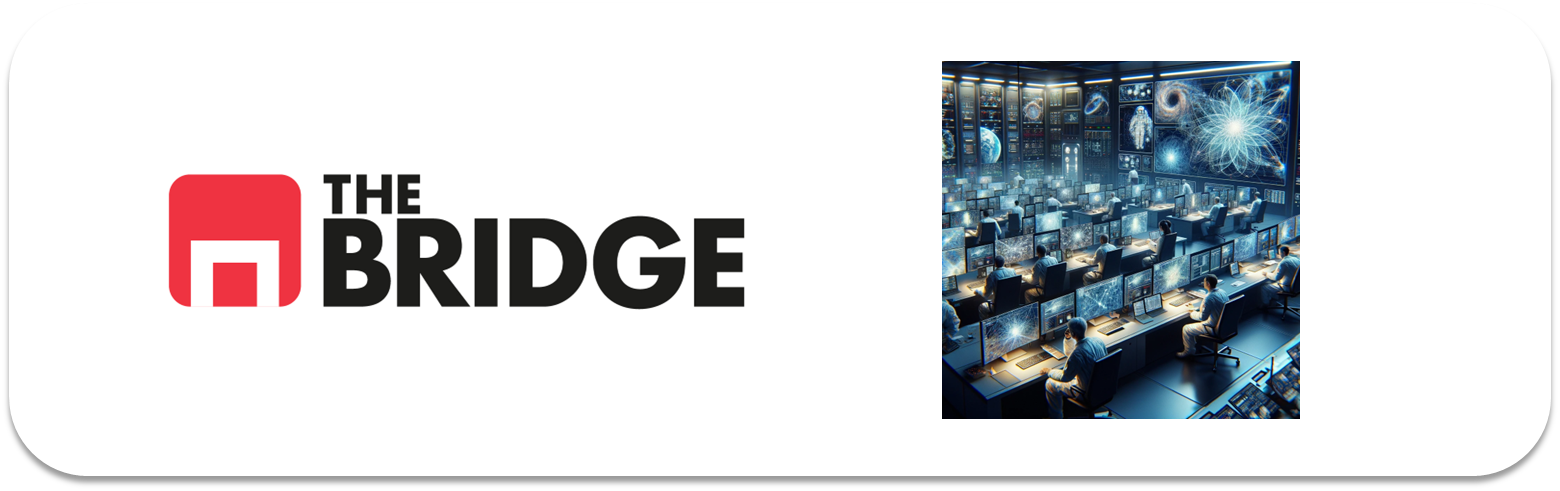

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import requests
from io import BytesIO
from zipfile import ZipFile

2025-03-08 18:38:40.643927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 18:38:40.720221: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-08 18:38:40.721692: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-08 18:38:42.030613: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Desactivar GPU si no está disponible
tf.config.set_visible_devices([], 'GPU')

In [4]:
# Descargar dataset de imágenes de paisajes si no está presente
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
dataset_path = "data/landscapes"

if not os.path.exists(dataset_path):
    os.makedirs(dataset_path, exist_ok=True)
    response = requests.get(dataset_url, stream=True)
    with open("data/flower_photos.tgz", "wb") as file:
        for chunk in response.iter_content(chunk_size=1024):
            file.write(chunk)
    # Extraer el dataset
    os.system("tar -xvzf data/flower_photos.tgz -C data")
    os.rename("data/flower_photos", dataset_path)

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454_0a64eb67fa.jpg
flower_pho

In [6]:
# Parámetros de imagen
target_size = (224, 224)
batch_size = 32

In [8]:
# Crear generadores de datos con ImageDataGenerator
data_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
train_generator = data_gen.flow_from_directory(
    dataset_path, target_size=target_size, batch_size=batch_size, class_mode='categorical', subset='training'
)
val_generator = data_gen.flow_from_directory(
    dataset_path, target_size=target_size, batch_size=batch_size, class_mode='categorical', subset='validation'
)

Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


In [9]:
# Selección del modelo preentrenado (MobileNetV2 por ser ligero)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Congelo pesos para Transfer Learning

In [10]:
# Construcción de la nueva cabeza del modelo
head_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

In [11]:
# Compilo el modelo
head_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
# Defino EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [13]:
# Entreno el modelo (Transfer Learning)
history_tl = head_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
92/92 [==============================] - 30s 290ms/step - loss: 0.7290 - accuracy: 0.7305 - val_loss: 0.4305 - val_accuracy: 0.8605
Epoch 2/10
92/92 [==============================] - 26s 280ms/step - loss: 0.3927 - accuracy: 0.8598 - val_loss: 0.4365 - val_accuracy: 0.8646
Epoch 3/10
92/92 [==============================] - 25s 274ms/step - loss: 0.3026 - accuracy: 0.8870 - val_loss: 0.3580 - val_accuracy: 0.8714
Epoch 4/10
92/92 [==============================] - 26s 277ms/step - loss: 0.2437 - accuracy: 0.9136 - val_loss: 0.3621 - val_accuracy: 0.8755
Epoch 5/10
92/92 [==============================] - 25s 276ms/step - loss: 0.2071 - accuracy: 0.9255 - val_loss: 0.3926 - val_accuracy: 0.8687
Epoch 6/10
92/92 [==============================] - 26s 279ms/step - loss: 0.1722 - accuracy: 0.9388 - val_loss: 0.3837 - val_accuracy: 0.8687
Epoch 7/10
92/92 [==============================] - 25s 274ms/step - loss: 0.1439 - accuracy: 0.9524 - val_loss: 0.4063 - val_accuracy: 0.8687

In [14]:
# Evaluación del modelo (Transfer Learning)
y_pred_tl = np.argmax(head_model.predict(val_generator), axis=1)
y_true = val_generator.classes
print("\nTransfer Learning - Reporte de Clasificación:\n", classification_report(y_true, y_pred_tl))

23/23 [==============================] - 6s 219ms/step

Transfer Learning - Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.18      0.17      0.18       126
           1       0.26      0.26      0.26       179
           2       0.18      0.18      0.18       128
           3       0.18      0.19      0.19       139
           4       0.19      0.19      0.19       159

    accuracy                           0.20       731
   macro avg       0.20      0.20      0.20       731
weighted avg       0.20      0.20      0.20       731



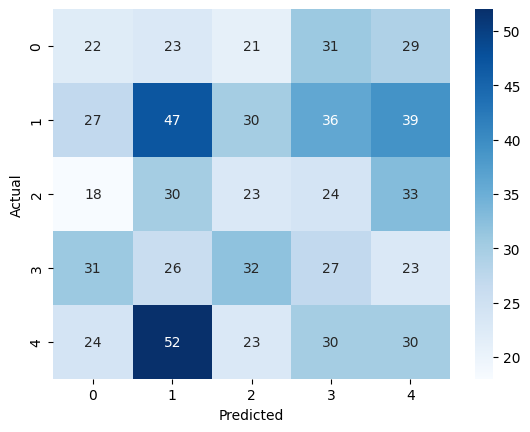

In [15]:
# Matriz de confusión Transfer Learning
conf_matrix_tl = confusion_matrix(y_true, y_pred_tl)
sns.heatmap(conf_matrix_tl, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [16]:
# Fine-Tuning: Descongelo algunas capas del modelo base
base_model.trainable = True
for layer in base_model.layers[:-10]:  # Congelar todas menos las últimas 10 capas
    layer.trainable = False

In [17]:
# Compilo nuevamente con una tasa de aprendizaje menor
head_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Entreno el modelo (Fine-Tuning)
history_ft = head_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stopping]
)

Epoch 1/10
92/92 [==============================] - 34s 319ms/step - loss: 0.3468 - accuracy: 0.8693 - val_loss: 0.4653 - val_accuracy: 0.8495
Epoch 2/10
92/92 [==============================] - 27s 293ms/step - loss: 0.2126 - accuracy: 0.9258 - val_loss: 0.5399 - val_accuracy: 0.8386
Epoch 3/10
92/92 [==============================] - 28s 302ms/step - loss: 0.1613 - accuracy: 0.9422 - val_loss: 0.4514 - val_accuracy: 0.8632
Epoch 4/10
92/92 [==============================] - 27s 292ms/step - loss: 0.1176 - accuracy: 0.9585 - val_loss: 0.5408 - val_accuracy: 0.8482
Epoch 5/10
92/92 [==============================] - 27s 292ms/step - loss: 0.1154 - accuracy: 0.9629 - val_loss: 0.5828 - val_accuracy: 0.8577
Epoch 6/10
92/92 [==============================] - 27s 294ms/step - loss: 0.0803 - accuracy: 0.9779 - val_loss: 0.4409 - val_accuracy: 0.8728
Epoch 7/10
92/92 [==============================] - 27s 292ms/step - loss: 0.0558 - accuracy: 0.9857 - val_loss: 0.5062 - val_accuracy: 0.8687

In [19]:
# Evaluación del modelo (Fine-Tuning)
y_pred_ft = np.argmax(head_model.predict(val_generator), axis=1)
print("\nFine-Tuning - Reporte de Clasificación:\n", classification_report(y_true, y_pred_ft))

23/23 [==============================] - 6s 218ms/step

Fine-Tuning - Reporte de Clasificación:
               precision    recall  f1-score   support

           0       0.19      0.17      0.18       126
           1       0.29      0.25      0.26       179
           2       0.14      0.10      0.12       128
           3       0.20      0.22      0.21       139
           4       0.22      0.30      0.25       159

    accuracy                           0.21       731
   macro avg       0.21      0.21      0.20       731
weighted avg       0.21      0.21      0.21       731



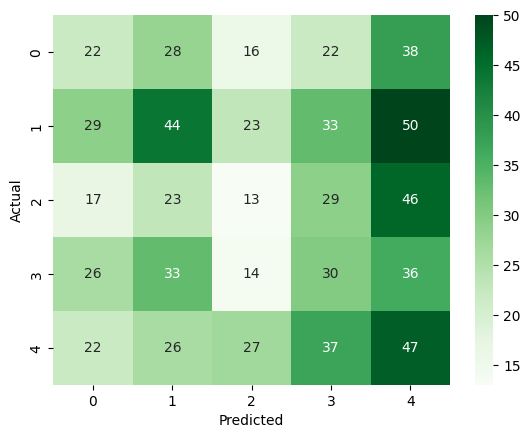

In [20]:
# Matriz de confusión Fine-Tuning
conf_matrix_ft = confusion_matrix(y_true, y_pred_ft)
sns.heatmap(conf_matrix_ft, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [21]:
# Comparación de resultados
print("\nComparación de precisión:\n")
print(f"Transfer Learning - Precisión: {max(history_tl.history['val_accuracy'])}")
print(f"Fine-Tuning - Precisión: {max(history_ft.history['val_accuracy'])}")


Comparación de precisión:

Transfer Learning - Precisión: 0.8755130171775818
Fine-Tuning - Precisión: 0.8782489895820618
